In [64]:
# General imports
import os
import time
import random
import datetime
import glob
import pickle
import tqdm
import copy
import optuna
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from rich import print as rprint
from rich.pretty import pprint as rpprint
from tqdm import tqdm
from itertools import chain

# JAX + Keras
os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_USE_LEGACY_KERAS"] = "0"
import jax
import jax.numpy as jnp
import keras
from keras.models import Model
from keras.layers import Dense, Activation, Permute, Dropout
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import SeparableConv2D, DepthwiseConv2D
from keras.layers import BatchNormalization
from keras.layers import SpatialDropout2D
from keras.regularizers import l1_l2
from keras.layers import Input, Flatten
from keras.constraints import max_norm
from keras import backend as K

# Sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dataset
from custom_datasets.fatigue_mi import FatigueMI

%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
SKLRNG = 42
RNG = jax.random.PRNGKey(SKLRNG)

In [99]:
def data_generator(dataset, subjects = 1, filters = ([8, 32],), sfreq = 250):

    find_events = lambda raw, event_id: mne.find_events(raw, shortest_event=0, verbose=False) if len(mne.utils._get_stim_channel(None, raw.info, raise_error=False)) > 0 else mne.events_from_annotations(raw, event_id=event_id, verbose=False)[0]
    
    data = dataset.get_data(subjects=dataset.subject_list[:subjects])
    
    X = []
    y = []
    metadata = []

    for subject_id in data.keys():
        for session_id in data[subject_id].keys():
            for run_id in data[subject_id][session_id].keys():
                raw = data[subject_id][session_id][run_id]
                
                for fmin, fmax in filters:
                    raw = raw.filter(l_freq = fmin, h_freq = fmax, method = 'iir', picks = 'eeg', verbose = False)
                
                events = find_events(raw, dataset.event_id)

                tmin = dataset.interval[0]
                tmax = dataset.interval[1]
                
                stim_channels = mne.utils._get_stim_channel(None, raw.info, raise_error=False)
                picks = mne.pick_channels(raw.info["ch_names"], include=[], exclude=stim_channels, ordered=True)

                x = mne.Epochs(
                    raw,
                    events,
                    event_id=dataset.event_id,
                    tmin=tmin,
                    tmax=tmax,
                    proj=False,
                    baseline=None,
                    preload=True,
                    verbose=False,
                    picks=picks,
                    event_repeated="drop",
                    on_missing="ignore",
                )
                x_events = x.events
                inv_events = {k: v for v, k in dataset.event_id.items()}
                labels = [inv_events[e] for e in x_events[:, -1]]
                
                x_resampled = x.resample(sfreq) # Resampler_Epoch
                x_resampled_data = x_resampled.get_data(copy=False) # Convert_Epoch_Array
                x_resampled_data_standard_scaler = np.asarray([
                    StandardScaler().fit_transform(x_resampled_data[i])
                    for i in np.arange(x_resampled_data.shape[0])
                ]) # Standard_Scaler_Epoch

                n = x_resampled_data_standard_scaler.shape[0]
                met = pd.DataFrame(index=range(n))
                met["subject"] = subject_id
                met["session"] = session_id
                met["run"] = run_id
                x.metadata = met.copy()
                
                X.append(x_resampled_data_standard_scaler)
                y.append(labels)
                metadata.append(met)

    return np.concatenate(X, axis=0), np.concatenate(y), pd.concat(metadata, ignore_index=True)

fat_dataset = FatigueMI()
# X, y, _ = data_generator(fat_dataset, subjects=len(fat_dataset.subject_list))
X, y, _ = data_generator(fat_dataset, subjects=32, sfreq=128)

Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns


{'X': (3456, 20, 256), 'y': (3456,)}

{'NUM_SAMPLES': 256, 'NUM_CHANNELS': 20, 'NUM_CLASSES': 2}

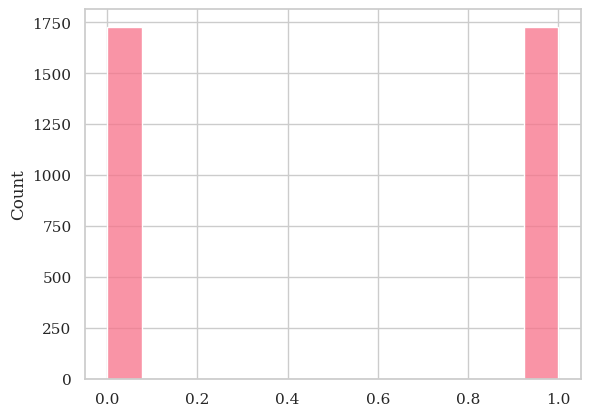

In [100]:
y_encoded = LabelEncoder().fit_transform(y) # 0 = left, 1 = right, 2 = unlabelled (!NOTE: should be ignored for binary classification)
# rpprint(y_encoded)
rprint({
    "X": X.shape,
    "y": y_encoded.shape
})

NUM_SAMPLES = X.shape[-1]
NUM_CHANNELS = X.shape[-2]
NUM_CLASSES = len(np.unique(y_encoded))

rpprint({
    "NUM_SAMPLES": NUM_SAMPLES,
    "NUM_CHANNELS": NUM_CHANNELS,
    "NUM_CLASSES": NUM_CLASSES
})

sns.histplot(y_encoded); # Plot the class distribution

In [103]:
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=TEST_SIZE, random_state=SKLRNG, stratify=y_encoded)

total = X_train.shape[0] + X_test.shape[0]
rpprint({
    "X_train": f"{X_train.shape[0]} ({X_train.shape[0] / total * 100:.2f}%)",
    "X_test": f"{X_test.shape[0]} ({X_test.shape[0] / total * 100:.2f}%)",
}, expand_all=True)

# batch_size = 32
# batches = batch_generator(X_train, batch_size, RNG)

{
│   'X_train': '2764 (79.98%)',
│   'X_test': '692 (20.02%)'
}

In [104]:
# region Helper funcs
def shallow_conv_net_square_layer(x):
    return jnp.square(x)

def shallow_conv_net_log_layer(x):
    return jnp.log(jnp.clip(x, 1e-7, 10000))

CUSTOM_OBJECTS = {
    "shallow_conv_net_square_layer": shallow_conv_net_square_layer, 
    "shallow_conv_net_log_layer": shallow_conv_net_log_layer 
}
# endregion Helper funcs

# region Models
def eeg_net(nb_classes = NUM_CLASSES, channels = NUM_CHANNELS, samples = NUM_SAMPLES, dropout_rate = 0.5, 
            kernLength = 64, F1 = 8, D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """
        From: https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
    """

    dropoutType = {'Dropout': Dropout, 'SpatialDropout2D': SpatialDropout2D}[dropoutType]

    input1   = Input(shape = (channels, samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (channels, samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((channels, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropout_rate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropout_rate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

def deep_conv_net(nb_classes = NUM_CLASSES, channels = NUM_CHANNELS, samples = NUM_SAMPLES, dropout_rate = 0.5):
    """
        From: https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
    """
    input_main   = Input((channels, samples, 1))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(channels, samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (channels, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropout_rate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropout_rate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropout_rate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropout_rate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

def shallow_conv_net(nb_classes = NUM_CLASSES, channels = NUM_CHANNELS, samples = NUM_SAMPLES, dropout_rate = 0.5, **kwargs):
    """
        From: https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
    """

    _POOL_SIZE_ = kwargs.get("pool_size", (1, 35))
    _STRIDES_ = kwargs.get("strides", (1, 7))
    _CONV_FILTERS_ = kwargs.get("conv_filters", (1, 13))

    input_main   = Input(shape=(channels, samples, 1))
    block1       = Conv2D(40, _CONV_FILTERS_,
                                 input_shape=(channels, samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (channels, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation(shallow_conv_net_square_layer)(block1)
    block1       = AveragePooling2D(pool_size=_POOL_SIZE_, strides=_STRIDES_)(block1)
    block1       = Activation(shallow_conv_net_log_layer)(block1)
    block1       = Dropout(dropout_rate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

# endregion Models

In [105]:
model = shallow_conv_net()
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    # validation_data=(X_val, y_val),
    validation_split=0.2,
    callbacks=[
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=75, restore_best_weights=True),
        # keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=75, factor=0.5)
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1)
    ],
)

Epoch 1/10


/home/araz/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.5064 - loss: 0.7305 - val_accuracy: 0.5009 - val_loss: 0.7218 - learning_rate: 0.0010
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.6075 - loss: 0.6621 - val_accuracy: 0.4720 - val_loss: 0.7305 - learning_rate: 0.0010
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.6731 - loss: 0.6091 - val_accuracy: 0.5208 - val_loss: 0.7411 - learning_rate: 0.0010
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.7042 - loss: 0.5764 - val_accuracy: 0.4774 - val_loss: 0.7652 - learning_rate: 0.0010
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.7640 - loss: 0.5186 - val_accuracy: 0.4973 - val_loss: 0.7494 - learning_rate: 1.0000e-04
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.7679 - loss: 0.5109 - val_accuracy: 0.5099 - val_loss: 0.7454 - learning_rate: 1.0000e-04


In [106]:
# results_val = model.evaluate(X_val, y_val, batch_size=32)
results_test = model.evaluate(X_test, y_test, batch_size=24)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4624 - loss: 0.7280


In [108]:
# Model/pipeline hyperparameter optimization test
data_store_dict = {}

def objective_fn(trial, **kwargs):
    global data_store_dict
    
    # _SFREQ_ = trial.suggest_categorical("sfreq", [128, 250])
    _SFREQ_ = 128
    # _TRAIN_SIZE_ = trial.suggest_categorical("train_size", [0.8, 0.9])
    _TRAIN_SIZE_ = 0.8
    _TEST_SIZE_ = 1 - _TRAIN_SIZE_

    if _SFREQ_ in data_store_dict:
        X, y, _ = data_store_dict[_SFREQ_]
    else:
        X, y, _ = data_generator(fat_dataset, subjects=10, sfreq=_SFREQ_)
        data_store_dict[_SFREQ_] = (X, y, _)
    
    y_encoded = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=_TEST_SIZE_, random_state=SKLRNG, stratify=y_encoded)
    _NUM_SAMPLES_ = X.shape[-1]
    _NUM_CHANNELS_ = X.shape[-2]
    _NUM_CLASSES_ = len(np.unique(y_encoded))
    
    model_params = {
        "nb_classes": _NUM_CLASSES_,
        "channels": _NUM_CHANNELS_,
        "samples": _NUM_SAMPLES_,
        "dropout_rate": trial.suggest_float("dropout_rate", 0.1, 0.9),
        "pool_size": trial.suggest_categorical("pool_size", [(1, 35), (1, 75)]),
        "strides": trial.suggest_categorical("strides", [(1, 7), (1, 15)]),
        "conv_filters": trial.suggest_categorical("conv_filters", [(1, 13), (1, 25)]),
    }

    model = shallow_conv_net(**model_params)
    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer="adam", 
        metrics=["accuracy"]
    )
    
    history = model.fit(
        X_train,
        y_train,
        batch_size=64,
        epochs=10,
        # validation_data=(X_val, y_val),
        validation_split=0.2,
        callbacks=[
            # keras.callbacks.EarlyStopping(monitor="val_loss", patience=75, restore_best_weights=True),
            # keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=75, factor=0.5)
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1)
        ],
    )
    
    return np.mean(history.history["val_accuracy"][-3:])

def heuristic_optimizer(max_iter = 10, show_progress_bar = True, **kwargs):
    
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    
    # study = optuna.create_study(direction="maximize", sampler=optuna.samplers.CmaEsSampler())
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.NSGAIISampler())
    study.optimize(objective_fn, n_trials=max_iter, show_progress_bar=show_progress_bar, callbacks=[], **kwargs)

    return study

study = heuristic_optimizer()

  0%|          | 0/10 [00:00<?, ?it/s]

Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Epoch 1/10


/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 15) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 35) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 75) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, flo

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step - accuracy: 0.5280 - loss: 0.7061 - val_accuracy: 0.4682 - val_loss: 0.9252 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.6675 - loss: 0.6288 - val_accuracy: 0.5318 - val_loss: 0.7048 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.7861 - loss: 0.5399 - val_accuracy: 0.4971 - val_loss: 0.7715 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.8311 - loss: 0.4570 - val_accuracy: 0.5260 - val_loss: 0.7579 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.8894 - loss: 0.3805 - val_accuracy: 0.5145 - val_loss: 0.7826 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.8857 - loss: 0.3378 - val_accuracy: 0.5202 - val_loss: 0.7823 - learning_rate: 1.0000e-04
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.9234 - loss: 0.3060 - val_acc

/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 15) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 35) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 75) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, flo

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step - accuracy: 0.5159 - loss: 0.7372 - val_accuracy: 0.4682 - val_loss: 0.8360 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.6729 - loss: 0.6165 - val_accuracy: 0.5434 - val_loss: 0.6959 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.8137 - loss: 0.5102 - val_accuracy: 0.5087 - val_loss: 0.8634 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.8789 - loss: 0.4073 - val_accuracy: 0.4913 - val_loss: 0.8086 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.8877 - loss: 0.3435 - val_accuracy: 0.4913 - val_loss: 0.8119 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.9060 - loss: 0.3087 - val_accuracy: 0.4798 - val_loss: 0.8036 - learning_rate: 1.0000e-04
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.9324 - loss: 0.2817 - val_acc

/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 15) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 35) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 75) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, flo

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.4914 - loss: 0.9136 - val_accuracy: 0.4393 - val_loss: 0.8063 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.5255 - loss: 0.7215 - val_accuracy: 0.4740 - val_loss: 0.7432 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.6311 - loss: 0.6660 - val_accuracy: 0.5029 - val_loss: 0.7367 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.6231 - loss: 0.6569 - val_accuracy: 0.5202 - val_loss: 0.7217 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.6633 - loss: 0.6133 - val_accuracy: 0.5549 - val_loss: 0.7185 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.6710 - loss: 0.6087 - val_accuracy: 0.5723 - val_loss: 0.7155 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.6812 - loss: 0.5586 - val_accurac

/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 15) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 35) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 75) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, flo

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 339ms/step - accuracy: 0.4653 - loss: 0.9077 - val_accuracy: 0.4682 - val_loss: 0.8564 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.5575 - loss: 0.6945 - val_accuracy: 0.4855 - val_loss: 0.7308 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.5482 - loss: 0.7139 - val_accuracy: 0.4509 - val_loss: 0.7133 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.5847 - loss: 0.6750 - val_accuracy: 0.5087 - val_loss: 0.7007 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.6006 - loss: 0.6517 - val_accuracy: 0.5549 - val_loss: 0.6964 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.5891 - loss: 0.6648 - val_accuracy: 0.5434 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.5956 - loss: 0.6501 - val_accurac

/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 15) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 35) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 75) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, flo

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - accuracy: 0.5223 - loss: 0.7897 - val_accuracy: 0.4682 - val_loss: 0.7123 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.5051 - loss: 0.7064 - val_accuracy: 0.4682 - val_loss: 0.7383 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - accuracy: 0.5281 - loss: 0.6861 - val_accuracy: 0.4913 - val_loss: 0.7057 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.5798 - loss: 0.6696 - val_accuracy: 0.5491 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.6000 - loss: 0.6641 - val_accuracy: 0.5665 - val_loss: 0.6875 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.6073 - loss: 0.6436 - val_accuracy: 0.5723 - val_loss: 0.6776 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.6496 - loss: 0.6333 - val_accurac

/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 15) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 35) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 75) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, flo

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step - accuracy: 0.5112 - loss: 0.7199 - val_accuracy: 0.4682 - val_loss: 1.7977 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.7058 - loss: 0.6193 - val_accuracy: 0.4624 - val_loss: 0.8873 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.8087 - loss: 0.5356 - val_accuracy: 0.4682 - val_loss: 0.7591 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.8890 - loss: 0.4577 - val_accuracy: 0.5491 - val_loss: 0.7187 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9085 - loss: 0.3864 - val_accuracy: 0.5202 - val_loss: 0.7201 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.9386 - loss: 0.3188 - val_accuracy: 0.6069 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9650 - loss: 0.2783 - val_accurac

/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 15) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 35) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 75) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, flo

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - accuracy: 0.5209 - loss: 0.8012 - val_accuracy: 0.4682 - val_loss: 2.8949 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.7263 - loss: 0.5799 - val_accuracy: 0.5260 - val_loss: 0.9680 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.8389 - loss: 0.4699 - val_accuracy: 0.4855 - val_loss: 0.8602 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.8550 - loss: 0.4027 - val_accuracy: 0.4740 - val_loss: 0.8282 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.9290 - loss: 0.3276 - val_accuracy: 0.4740 - val_loss: 0.8561 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.9457 - loss: 0.2741 - val_accuracy: 0.4451 - val_loss: 0.8717 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.9493 - loss: 0.2432 - val_accurac

/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 15) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 35) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 75) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, flo

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 348ms/step - accuracy: 0.5133 - loss: 1.0863 - val_accuracy: 0.5318 - val_loss: 0.9317 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.5441 - loss: 0.8143 - val_accuracy: 0.4682 - val_loss: 0.8331 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.6134 - loss: 0.7171 - val_accuracy: 0.5145 - val_loss: 0.7101 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.5964 - loss: 0.7651 - val_accuracy: 0.5491 - val_loss: 0.7090 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.6069 - loss: 0.7507 - val_accuracy: 0.5318 - val_loss: 0.7153 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.6398 - loss: 0.6259 - val_accuracy: 0.5202 - val_loss: 0.7249 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.6597 - loss: 0.6109 - val_accurac

/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 15) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 35) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 75) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, flo

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - accuracy: 0.4802 - loss: 0.7180 - val_accuracy: 0.4682 - val_loss: 1.0625 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.8272 - loss: 0.4855 - val_accuracy: 0.4740 - val_loss: 0.8391 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.9390 - loss: 0.3455 - val_accuracy: 0.4913 - val_loss: 0.8220 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.9687 - loss: 0.2565 - val_accuracy: 0.5260 - val_loss: 0.8279 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.9844 - loss: 0.1719 - val_accuracy: 0.5376 - val_loss: 0.8696 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9948 - loss: 0.1372 - val_accuracy: 0.5145 - val_loss: 0.8729 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.9983 - loss: 0.1095 - val_accurac

/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 15) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 35) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 75) which is of type tuple.
  warnings.warn(message)
/home/araz/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, flo

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - accuracy: 0.4934 - loss: 0.7116 - val_accuracy: 0.4971 - val_loss: 0.7108 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.6603 - loss: 0.6565 - val_accuracy: 0.4566 - val_loss: 0.7324 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.7146 - loss: 0.6282 - val_accuracy: 0.5029 - val_loss: 0.7068 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.7634 - loss: 0.5742 - val_accuracy: 0.5434 - val_loss: 0.7041 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.8016 - loss: 0.5461 - val_accuracy: 0.5549 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.8179 - loss: 0.5024 - val_accuracy: 0.5607 - val_loss: 0.6831 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.8448 - loss: 0.4835 - val_accurac

In [123]:
study.best_params

{'dropout_rate': 0.170526350585544,
 'pool_size': (1, 75),
 'strides': (1, 15),
 'conv_filters': (1, 13)}

In [24]:
# Save model
model.save("model.keras")

In [8]:
# Load model from disk
loaded_model = keras.saving.load_model("model.keras", custom_objects=CUSTOM_OBJECTS)

In [10]:
## Pruning and quantization test

from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

baseline_model = loaded_model
pruning_params = {
    'pruning_schedule': pruning_wrapper.PolynomialDecay(initial_sparsity=0.00,
                                                        final_sparsity=0.80,
                                                        begin_step=0,
                                                        end_step=100)
}
sparse_model = pruning_wrapper.PruneLowMagnitude(baseline_model, **pruning_params)

sparse_model.summary()

RecursionError: maximum recursion depth exceeded while calling a Python object

### Data exploration, etc.

(540, 20, 129, 2)

[538 499 472 344]

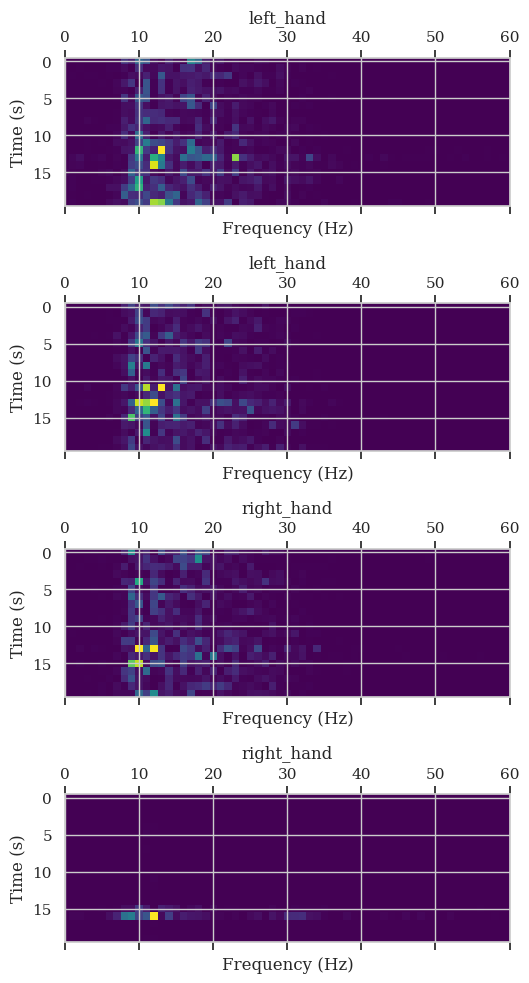

In [386]:
def create_spectrogram(epoch_data):
    spectrograms = []
    for epoch in epoch_data:
        epoch_spectrograms = []
        for channel in epoch:
            f, t, Sxx = sp.signal.spectrogram(channel, fs=50)
            epoch_spectrograms.append(Sxx)
        spectrograms.append(np.array(epoch_spectrograms))
    return np.array(spectrograms)

spectograms = create_spectrogram(X)
rprint(spectograms.shape) # (180, 21, 129, 2)

num_left_hand_epochs_to_visualize = 2
num_right_hand_epochs_to_visualize = 2

# Select epochs for visualization
left_hand_epochs_to_visualize = np.where((y == 'left_hand'))[0]
right_hand_epochs_to_visualize = np.where((y == 'right_hand'))[0]
left_hand_epochs_to_visualize = np.random.choice(left_hand_epochs_to_visualize, num_left_hand_epochs_to_visualize)
right_hand_epochs_to_visualize = np.random.choice(right_hand_epochs_to_visualize, num_right_hand_epochs_to_visualize)
epochs_to_visualize = np.concatenate((left_hand_epochs_to_visualize, right_hand_epochs_to_visualize))

rprint(epochs_to_visualize)

# Visualize spectrograms
fig, axs = plt.subplots(epochs_to_visualize.size, 1, figsize=(10, 10))
for i, idx in enumerate(epochs_to_visualize):
    axs[i].matshow(spectograms[idx, :, :, 0], cmap='viridis')
    axs[i].set_title(y[idx])
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Time (s)')
    axs[i].set_xlim(0, 60) # Limit x-axis to 60Hz

plt.tight_layout()
plt.show()